In [1]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import rankdata
from scipy.stats import ttest_ind

In [2]:
plt.rcParams.update({
    "axes.titlesize": 18,   # subplot titles
    "axes.labelsize": 16,   # x/y labels
    "xtick.labelsize": 14,  # x ticks
    "ytick.labelsize": 14,  # y ticks
})

In [3]:
df_clean = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
df_clean

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,true_class,pred_class,err_type,invalid,missed,...,date,expName,psychopyVersion,frameRate,expStart,Unnamed: 119,chosen_pos,Unnamed: 112,stim_ranks,resp_ranks
0,0.0,0.0,0.064,0.0,-0.18,0,1,1,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.064,NaN,11.5,34.5
1,1.0,0.0,-0.100,-0.0,-0.26,0,0,0,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.100,NaN,7.5,6.0
2,1.0,0.0,0.136,-0.0,0.34,1,1,0,True,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,-0.136,NaN,37.5,40.0
3,0.0,0.0,-0.136,0.0,-0.10,0,0,0,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,-0.136,NaN,15.5,4.0
4,0.0,0.0,0.056,0.0,-0.22,0,1,1,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.056,NaN,9.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.0,1.0,-0.236,-0.2,-0.38,0,0,0,False,False,...,2025-10-04_16h05.12.182,asymmetry_final,2024.2.4,60.0,2025-10-04 16h05.25.163659 -0600,NaN,0.236,NaN,2.5,10.0
1196,0.0,1.0,-0.240,-0.2,-0.26,0,0,0,False,False,...,2025-10-04_16h05.12.182,asymmetry_final,2024.2.4,60.0,2025-10-04 16h05.25.163659 -0600,NaN,0.240,NaN,14.5,8.5
1197,1.0,1.0,-0.220,-0.2,-0.22,0,0,0,False,False,...,2025-10-04_16h05.12.182,asymmetry_final,2024.2.4,60.0,2025-10-04 16h05.25.163659 -0600,NaN,-0.220,NaN,18.5,14.0
1198,0.0,1.0,-0.256,-0.2,-0.18,1,0,-1,False,False,...,2025-10-04_16h05.12.182,asymmetry_final,2024.2.4,60.0,2025-10-04 16h05.25.163659 -0600,NaN,0.256,NaN,21.5,6.0


In [4]:
# a function to choose whether plotting for subj or pop
def get_df(df, subj_or_pop):
    return subj_or_pop, df.copy() if subj_or_pop == 'pop' else df[df['subj'] == subj_or_pop].copy().reset_index(drop=True)

patients = df_clean['subj'].unique().tolist()
# pilots = ['A', 'T', 'E']

# test
subj_or_pop, df_analysis = get_df(df_clean, patients[0])
print(f'\nplotting for pt {subj_or_pop}\nlen(df) = {len(df_analysis)}')
df_analysis


plotting for pt 9
len(df) = 240


,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,true_class,pred_class,err_type,invalid,missed,...,date,expName,psychopyVersion,frameRate,expStart,Unnamed: 119,chosen_pos,Unnamed: 112,stim_ranks,resp_ranks
0,0.0,0.0,0.064,0.0,-0.18,0,1,1,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.064,NaN,11.5,34.5
1,1.0,0.0,-0.100,-0.0,-0.26,0,0,0,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.100,NaN,7.5,6.0
2,1.0,0.0,0.136,-0.0,0.34,1,1,0,True,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,-0.136,NaN,37.5,40.0
3,0.0,0.0,-0.136,0.0,-0.10,0,0,0,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,-0.136,NaN,15.5,4.0
4,0.0,0.0,0.056,0.0,-0.22,0,1,1,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.056,NaN,9.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.064,0.2,0.06,0,0,0,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.064,NaN,13.5,6.0
236,0.0,0.0,0.268,0.2,0.34,1,1,0,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.268,NaN,34.5,38.0
237,0.0,0.0,0.264,0.2,0.34,1,1,0,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,0.264,NaN,34.5,37.0
238,1.0,0.0,0.104,0.2,-0.10,0,0,0,False,False,...,2025-05-23_14h44.58.284,asymmetry_final,2024.2.4,60.0,2025-05-23 14h45.10.782086 -0600,NaN,-0.104,NaN,5.5,11.0


# 3. checks

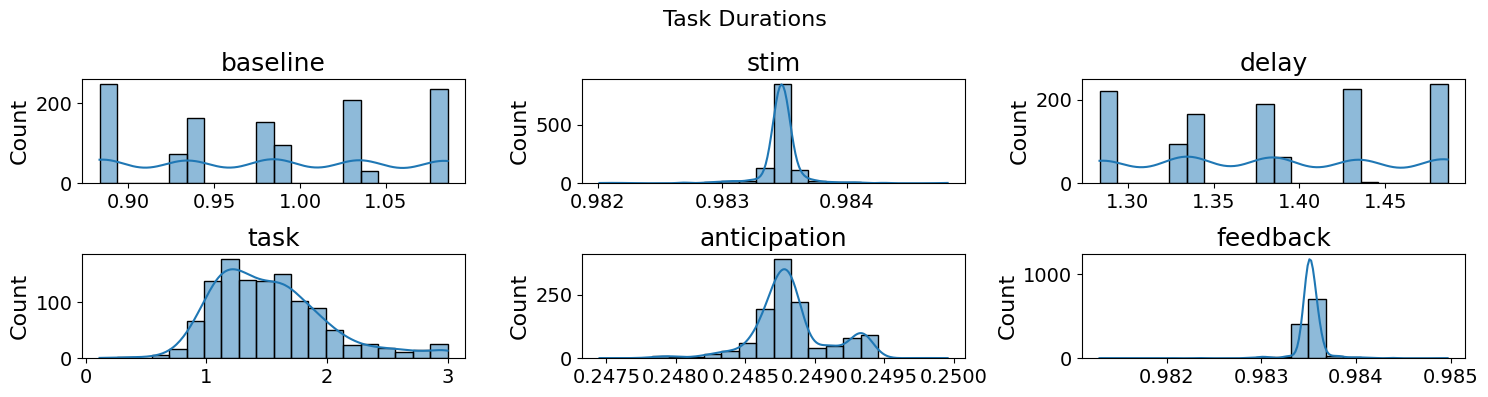

In [5]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# create column for each phases's duration
expt_phases = ['baseline', 'stim', 'delay', 'task', 'anticipation', 'feedback']
for phase in expt_phases:
    df_analysis[f'{phase}_dur'] = df_analysis[f'{phase}.stopped'] - df_analysis[f'{phase}.started']

# sid, check if these are needed replacements
df_analysis['stim_dur'] = df_analysis['stim.stopped'] - df_analysis['target_stim.started']
df_analysis['feedback_dur'] = df_analysis['feedback.stopped'] - df_analysis['no_resp_text.started']

fig, axs = plt.subplots(2, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0

for expt_phase in expt_phases:

    sns.histplot(df_analysis[f'{expt_phase}_dur'], bins=20, kde=True, ax=axs[ax])
    axs[ax].set(title=expt_phase, xlabel='', ylabel='Count')
    ax += 1

plt.suptitle(f'Task Durations', fontsize=16)
plt.tight_layout()
plt.show()

# print which trials with feedback duration < .99
# short_feedback = df_analysis.loc[df_analysis['feedback_dur'] < 0.998]
# print(f'{len(short_feedback)} trials: {short_feedback.index.tolist()}')

In [6]:
subj_or_pop, df_analysis = get_df(df_clean, patients[2])

num_missed = df_analysis['missed'].sum()
num_invalid = df_analysis['invalid'].sum()
num_purely_incorrect = df_analysis['purely_incorrect'].sum()
print(f'patient: {subj_or_pop}')
print(f'\
missed: {num_missed} ({num_missed / 240 * 100:.2f}%),\
 invalid: {num_invalid} ({num_invalid / 240 * 100:.2f}%),\
 incorrect: {num_purely_incorrect} ({num_purely_incorrect / 240 * 100:.2f}%)')

# proportion correct
prop_correct = df_analysis['correct'].mean()
print(f'Proportion correct: {prop_correct:.2f}')

# pearson and spearman correlations between stim_pos_aligned and chosen_pos_aligned
pearson_corr = df_analysis['stim_pos_aligned'].corr(df_analysis['chosen_pos_aligned'], method='pearson')
spearman_corr = df_analysis['stim_pos_aligned'].corr(df_analysis['chosen_pos_aligned'], method='spearman')
print(f'Pearson correlation: {pearson_corr:.2f}')
print(f'Spearman correlation: {spearman_corr:.2f}')

# ensure this is the same
pearson_corr = df_analysis['target_pos'].corr(df_analysis['chosen_pos'], method='pearson')
spearman_corr = df_analysis['target_pos'].corr(df_analysis['chosen_pos'], method='spearman')

print(df_analysis['outcome'].value_counts(), '\n')


patient: 12
missed: 0 (0.00%), invalid: 1 (0.42%), incorrect: 15 (6.25%)
Proportion correct: 0.93
Pearson correlation: 0.77
Spearman correlation: 0.74
outcome
 3.0    113
 1.0    111
-3.0      9
-1.0      7
Name: count, dtype: int64 



## plotting vars

In [20]:
conds = ['pen_comp', 'baseline', 'rew_comp']
cond2name = {'pen_comp': 'gain_exp', 'baseline': 'baseline', 'rew_comp': 'loss_exp'}
pt_colors = ['g','r','orange','b', 'purple']

## NOTE: p_vals sigfig only when i exclude invalid/missed trials

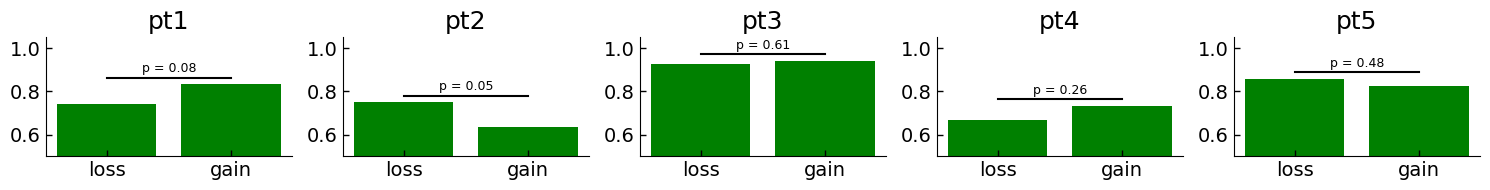

In [13]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')
# drop missed or invalid trials
# df_analysis = df_analysis[~df_analysis['missed'] & ~df_analysis['invalid']]

n_rows, n_cols = 1, len(patients)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
axs, ax = axs.flatten(), 0

for subj_idx in range(len(patients)):

    subj_df = df_analysis[df_analysis['subj'] == patients[subj_idx]].copy()
    acc_by_contxt = subj_df.groupby('true_class')['correct'].mean()

    # axs[ax].bar(acc_by_contxt.index, acc_by_contxt.values, color=[pt_colors[subj_idx]])
    axs[ax].bar(acc_by_contxt.index, acc_by_contxt.values, color='g')
    axs[ax].set(title =f'pt{subj_idx+1}',
                ylim=(.5, 1.05), xticks=[0, 1], xticklabels=['loss', 'gain'])

    # stats
    loss_acc = subj_df[subj_df['true_class'] == 0]['correct']
    gain_acc = subj_df[subj_df['true_class'] == 1]['correct']
    # simple independent-samples t-test on trial accuracies
    tval, pval = ttest_ind(loss_acc, gain_acc, equal_var=False)

    # 💬 Add p-value line + text on figure
    y_max = max(acc_by_contxt.values)
    y_line = y_max + 0.03
    axs[ax].plot([0, 1], [y_line, y_line], color='k', lw=1.5)
    axs[ax].text(0.5, y_line + 0.01, f"p = {pval:.2f}", ha='center', va='bottom', fontsize=9)

    ax += 1

for ax in axs:
    ax.tick_params(direction='in', length=4, width=1)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# plt.suptitle('Categorization Accuracy by Reward Context', fontsize=20)
plt.tight_layout()
plt.show()
# save as eps
# fig.savefig('../../results/figs/sfn/fig3a_accuracy.eps', format='eps', dpi=300)
plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
fig.savefig('../../results/figs/sfn/fig3a_accuracy.svg', format='svg', dpi=300)

plotting vars

In [21]:
cond2name = {'pen_comp': 'gain_exp', 'baseline': 'baseline', 'rew_comp': 'loss_exp'}

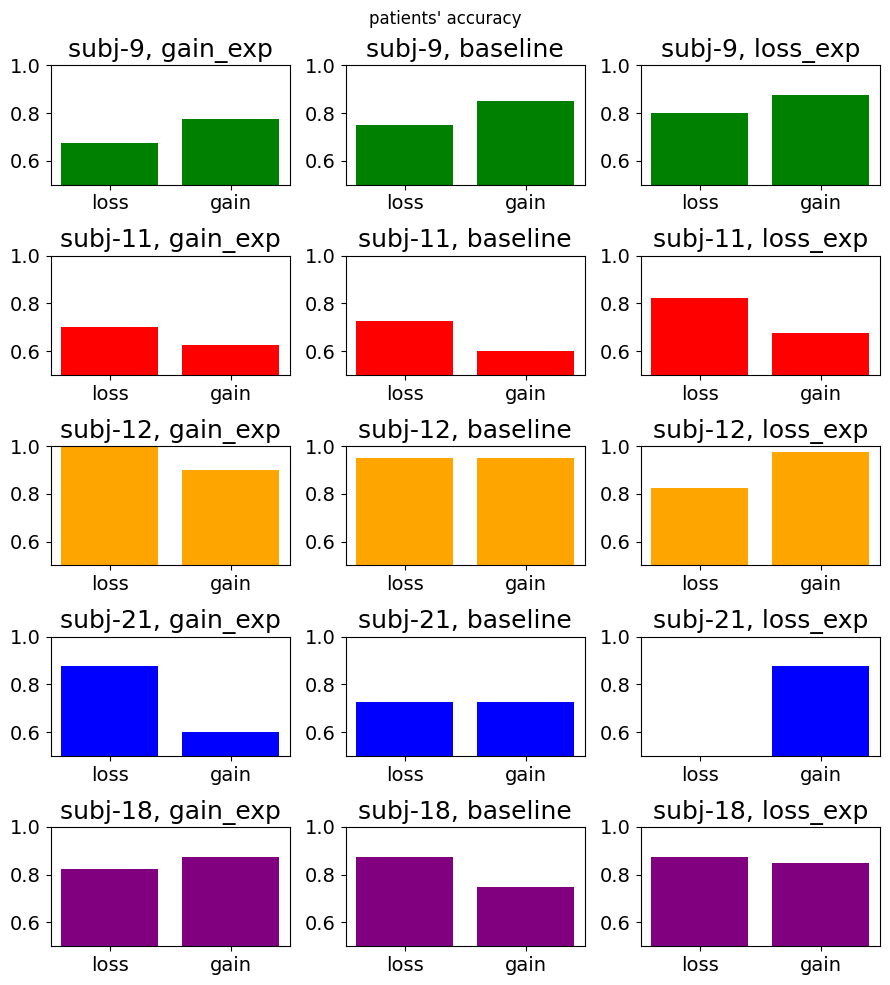

In [23]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

n_rows, n_cols = len(patients), 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
axs, ax = axs.flatten(), 0

# pilotOrpatient = 1
# subjs2plot = [pilots, patients][pilotOrpatient]
# subj_title = ['pilots', 'patients'][pilotOrpatient]

for pt_idx in range(len(patients)):

    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == patients[pt_idx]) & (df_analysis['condition'] == cond)].copy()
        acc_by_contxt = subj_cond_df.groupby('true_class')['correct'].mean()

        axs[ax].bar(acc_by_contxt.index, acc_by_contxt.values, color=[pt_colors[pt_idx]])
        axs[ax].set(title=f'subj-{patients[pt_idx]}, {cond2name[cond]}', ylim=(.5, 1), xticks=[0, 1], xticklabels=['loss', 'gain'])
        ax += 1

# subplot adjust
plt.suptitle(f'patients\' accuracy')
plt.tight_layout()
plt.show()


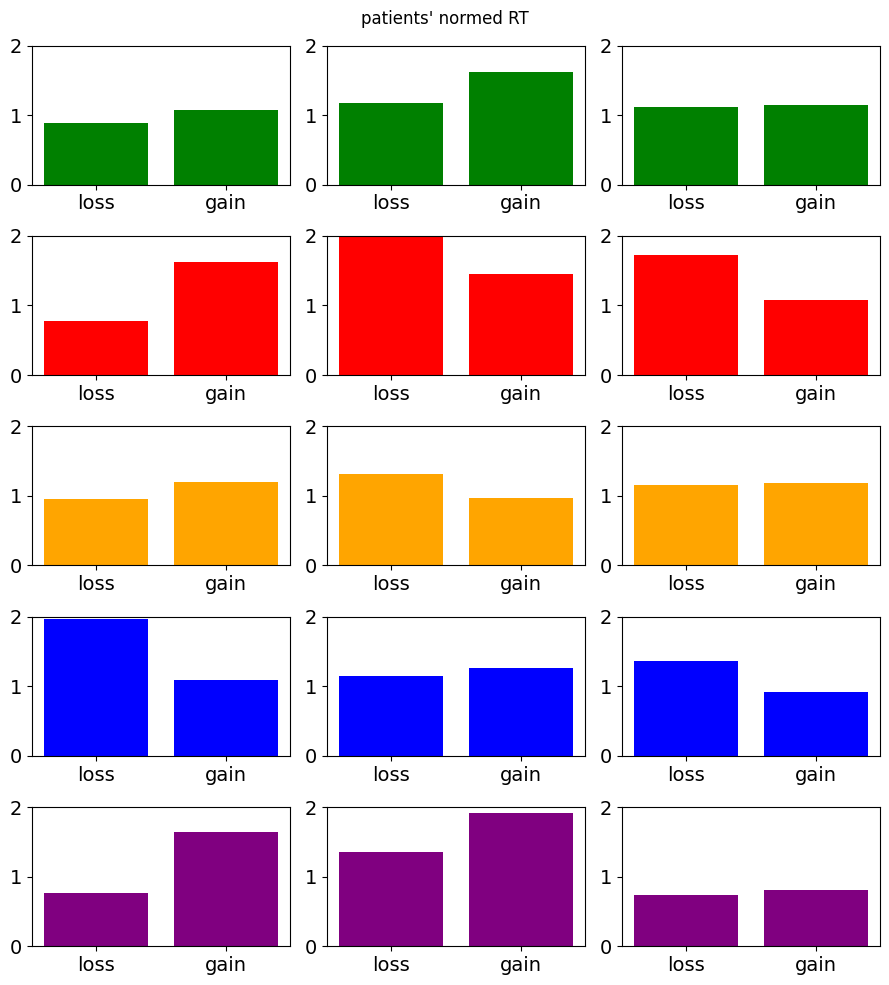

In [26]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

n_rows, n_cols = len(patients), 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
axs, ax = axs.flatten(), 0

# pilotOrpatient = 1
# subjs2plot = [pilots, patients][pilotOrpatient]
# subj_title = ['pilots', 'patients'][pilotOrpatient]

for pt_idx in range(len(patients)):

    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == patients[pt_idx]) & (df_analysis['condition'] == cond)].copy()
        
        RT_by_cntxt = subj_cond_df.groupby('true_class')['normed_RT'].mean()
        axs[ax].bar(RT_by_cntxt.index, RT_by_cntxt.values, color=[pt_colors[pt_idx]])
        
        axs[ax].set(ylim=(0, 2), xticks=[0, 1], xticklabels=['loss', 'gain'])
        ax += 1

# subplot adjust
plt.suptitle(f'patients\' normed RT')
plt.tight_layout()
plt.show()

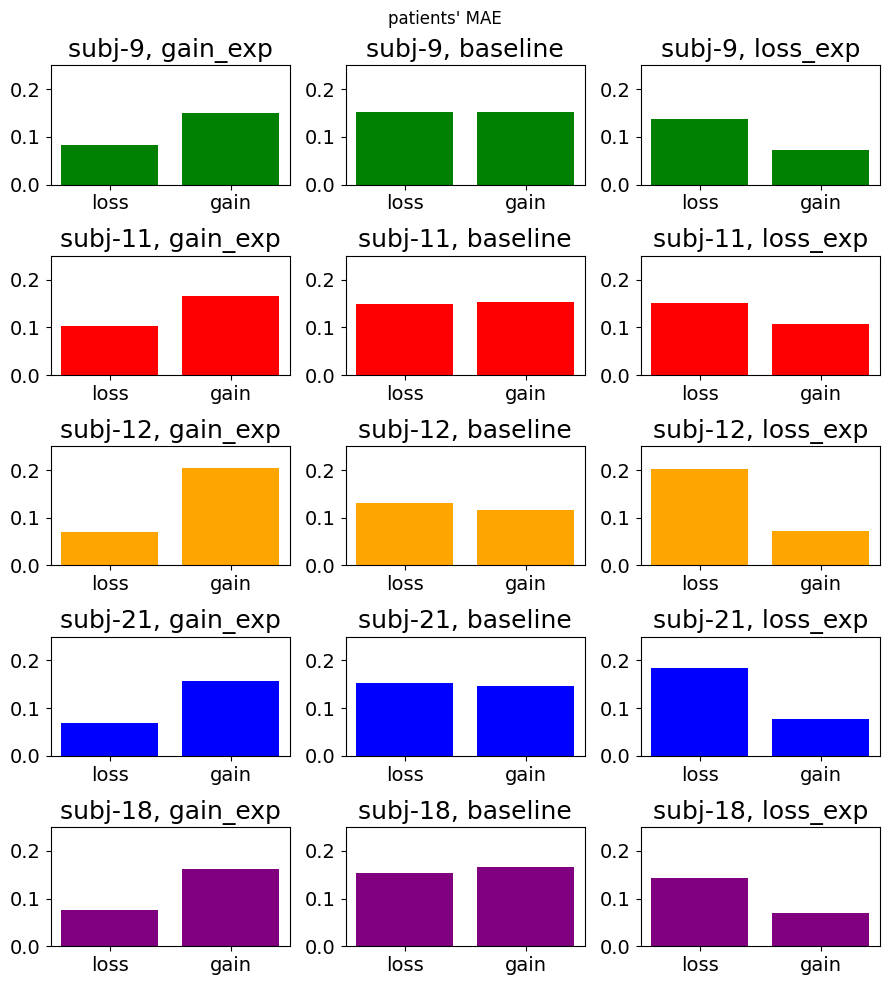

In [27]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

n_rows, n_cols = len(patients), 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
axs, ax = axs.flatten(), 0

# pilotOrpatient = 1
# subjs2plot = [pilots, patients][pilotOrpatient]
# subj_title = ['pilots', 'patients'][pilotOrpatient]

for pt_idx in range(len(patients)):

    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == patients[pt_idx]) & (df_analysis['condition'] == cond)].copy()
        
        subj_cond_df['abs_err'] = np.abs(subj_cond_df['stim_pos_aligned'] - subj_cond_df['chosen_pos_aligned'])
        err_by_stim = subj_cond_df.groupby('true_class')['abs_err'].mean()
        axs[ax].bar(err_by_stim.index, err_by_stim.values, color=[pt_colors[pt_idx]])

        axs[ax].set(title=f'subj-{patients[pt_idx]}, {cond2name[cond]}', 
                    ylim=(0, .25), xticks=[0, 1], xticklabels=['loss', 'gain'])

        ax += 1

plt.suptitle(f'patients\' MAE')
plt.tight_layout()
plt.show()

## post-error correction

## choice distribution

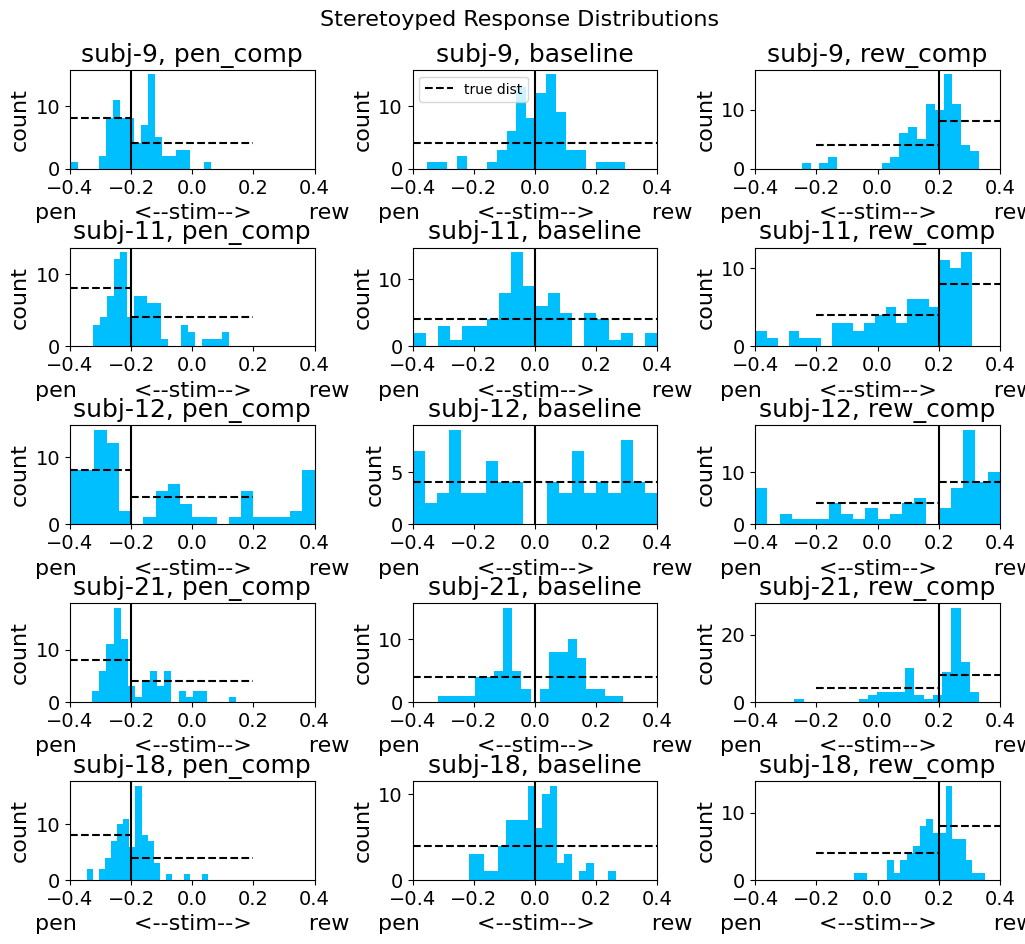

In [28]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

subjs = patients
# A. individual plots
fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 2*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        axs[ax].set(title=f'subj-{subj}, {cond}',
                    xlabel='pen        <--stim-->        rew', ylabel='count', xlim=(-.4, .4))
        axs[ax].hist(subj_cond_df['chosen_pos_aligned'], bins=20, color='deepskyblue')
        axs[ax].axvline(subj_cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
        
        # true dist line depends on cond
        if cond == 'baseline':
            axs[ax].axhline(4, color='black', linestyle='--', label='true dist')
        elif cond == 'pen_comp':
            axs[ax].hlines(8, -.4, -.2, color='black', linestyle='--', label='true dist')
            axs[ax].hlines(4, -.2, .2, color='black', linestyle='--')
        elif cond == 'rew_comp':
            axs[ax].hlines(4, -.2, .2, color='black', linestyle='--', label='true dist')
            axs[ax].hlines(8, .2, .4, color='black', linestyle='--')
        
        ax += 1

axs[1].legend()
plt.suptitle(f'Steretoyped Response Distributions', fontsize=16)
fig.subplots_adjust(wspace=.4, hspace=.8, top=.92)
plt.show()


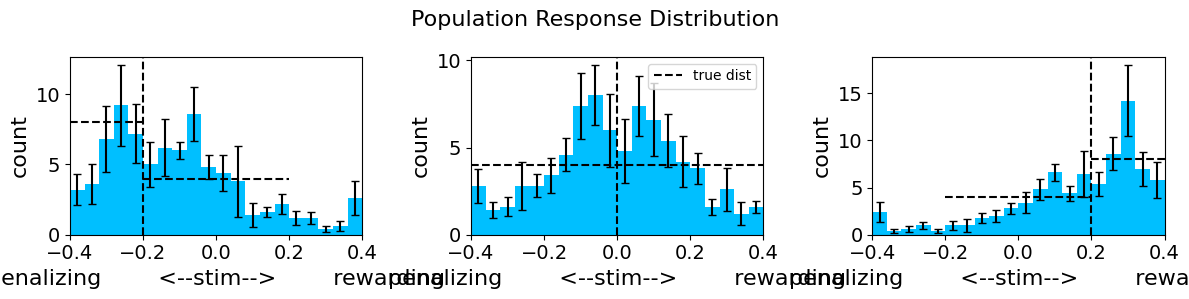

In [30]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# B. population
fig, axs = plt.subplots(1, 3, figsize=(4*len(conds), 3))
axs, ax = axs.flatten(), 0

for cond in conds:
    cond_df = df_analysis[df_analysis['condition'] == cond].copy()

    # compute a histogram of responses per subj
    resp_cts = []
    for subj, subj_df in cond_df.groupby('subj'):
        counts, _ = np.histogram(subj_df['chosen_pos_aligned'], bins=20)
        resp_cts.append(counts)
    resp_cts = np.array(resp_cts)

    mean_resp_cts = resp_cts.mean(axis=0)
    sen_resp_cts = resp_cts.std(axis=0) / np.sqrt(resp_cts.shape[0])

    # plot
    axs[ax].bar(np.linspace(-.38,.38,20), mean_resp_cts, width=.04,
                color='deepskyblue', yerr=sen_resp_cts, capsize=3)

    axs[ax].set(xlabel='penalizing        <--stim-->        rewarding',
                ylabel='count', xlim=(-.4, .4))

    # divider
    axs[ax].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='--')

    # true dist lines
    if cond == 'baseline':
        axs[ax].axhline(4, color='black', linestyle='--', label='true dist')
    elif cond == 'pen_comp':
        axs[ax].hlines(8, -.4, -.2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(4, -.2, .2, color='black', linestyle='--')
    elif cond == 'rew_comp':
        axs[ax].hlines(4, -.2, .2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(8, .2, .4, color='black', linestyle='--')
 
    ax += 1

axs[1].legend()
plt.suptitle(f'Population Response Distribution', fontsize=16)
plt.tight_layout()
plt.show()


## stim vs resp

In [31]:
# # choose what youre plotting
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# # plot info
# color_map = {False: 'orange', True: 'deepskyblue'}
# label_map = {False: 'incorrect', True: 'correct'}

# n_rows, n_cols = 4, 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
# axs, ax = axs.flatten(), 0
# ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)

# for subj in patients:

#     for cond in conds:
#         subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

#         # SETUP
#         # diagonal for perfect accuracy
#         axs[ax].plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)

#         # # calculate and plot performance
#         # pearson_r = subj_cond_df['stim_pos_aligned'].corr(subj_cond_df['chosen_pos_aligned'], method='pearson')
#         # accuracy = subj_cond_df['correct'].mean()
#         # axs[ax].text(0.05, 0.95, f'class_acc = {accuracy:.2f}\npearson r = {pearson_r:.2f}', 
#         #             transform=axs[ax].transAxes, verticalalignment='top',
#         #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.4))
            
#         # divider
#         div_pos = subj_cond_df['div_pos_aligned'].iloc[0]
#         axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
#         axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)
        
#         # set
#         # axs[ax].set(title=f'subj-{ax+1}', xlabel='shape position', ylabel='response position',
#         #             xlim=(-.4, .4), ylim=(-.4, .4),
#         #             xticks=ticks, xticklabels=labels, yticks=ticks, yticklabels=labels)

#         axs[ax].set(xlabel='shape position', ylabel='response position',
#                     xlim=(-.4, .4), ylim=(-.4, .4),
#                     xticks=ticks, xticklabels=labels, yticks=ticks, yticklabels=labels)
                
#         # PLOT
#         # points
#         for acc, acc_df in subj_cond_df.groupby('correct'):        
#             axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'],
#                             color=color_map[acc], label=label_map[acc])
                
#         # Calculate mean and SD of chosen position for each stimulus position
#         mean_chosen_per_stim = subj_cond_df.groupby('stim_pos_aligned')['chosen_pos_aligned'].agg(['mean', 'std']).reset_index()
#         mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_pos_aligned')
        
#         # mean
#         axs[ax].plot(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], color='red')
        
#         # err bars
#         axs[ax].errorbar(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], 
#                         yerr=mean_chosen_per_stim['std'], color= 'red')

#         ax += 1

# axs[1].legend()
# plt.suptitle('Example Patient Responses across Conditions', fontsize=20)
# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
# # plt.tight_layout()
# plt.show()


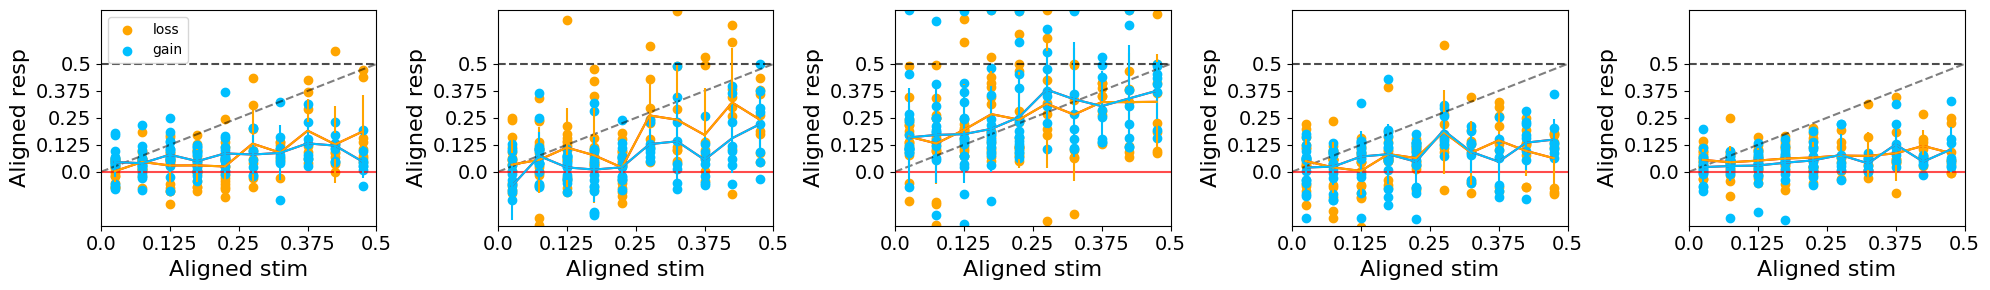

In [34]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
color_map = {0: 'orange', 1: 'deepskyblue'}
label_map = {0: 'loss', 1: 'gain'}

n_rows, n_cols = len(patients), 3
n_rows, n_cols = 1, len(patients)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axs, ax = axs.flatten(), 0
# ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    subj_df = df_analysis[df_analysis['subj'] == subj].copy()

    # for cond in conds:
    #     subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

    axs[ax].plot([0, .4], [0, .4], 'k--', alpha=0.5) # diagonal
    axs[ax].axhline(0, color='red', linestyle='-', alpha=0.7) # correct classification
    axs[ax].axhline(.4, color='black', linestyle='--', alpha=0.7) # only in expanded conds

    axs[ax].set(xlabel='Aligned stim', ylabel='Aligned resp',# title=f'pt-{subj}',
                xlim=(0, .4), ylim=(-.2, .6),
                xticks=ticks, yticks=ticks, xticklabels=labels, yticklabels=labels)
            
    # scatter
    for cntxt, cntxt_df in subj_df.groupby('true_class'):
                
        axs[ax].scatter(cntxt_df['stim_aligned_to_cntxt'], cntxt_df['resp_aligned_to_cntxt'],
                        color=color_map[cntxt], label=label_map[cntxt])

        # Calculate mean and SD of chosen position for each stimulus position
        mean_chosen_per_stim = cntxt_df.groupby('stim_aligned_to_cntxt')['resp_aligned_to_cntxt'].agg(['mean', 'std']).reset_index()
        mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
        
        # mean
        axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
        
        # err bars
        axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
                        yerr=mean_chosen_per_stim['std'], color=color_map[cntxt])

    axs[0].legend()
    ax += 1

# plt.suptitle('Stimulus vs response for gain vs. loss trials', fontsize=20)
# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout()
plt.show()


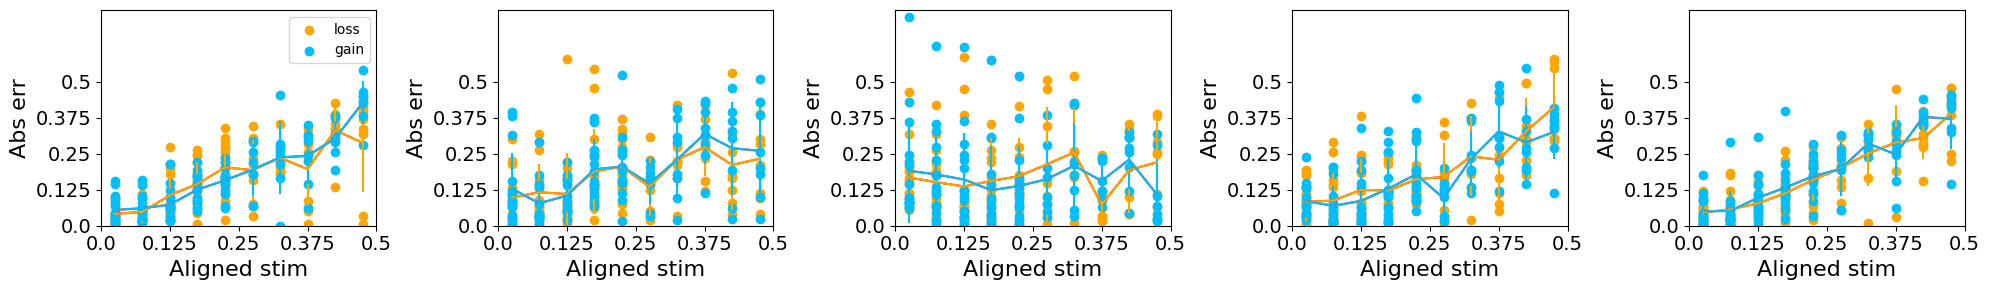

In [35]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
color_map = {0: 'orange', 1: 'deepskyblue'}
label_map = {0: 'loss', 1: 'gain'}

n_rows, n_cols = len(patients), 3
n_rows, n_cols = 1, len(patients)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axs, ax = axs.flatten(), 0
# ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    subj_df = df_analysis[df_analysis['subj'] == subj].copy()

    # for cond in conds:
    #     subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

    axs[ax].set(xlabel='Aligned stim', ylabel='Abs err',# title=f'pt-{subj}',
                xlim=(0, .4), ylim=(.0, .6),
                xticks=ticks, yticks=ticks, xticklabels=labels, yticklabels=labels)
            
    # scatter
    for cntxt, cntxt_df in subj_df.groupby('true_class'):
                
        axs[ax].scatter(cntxt_df['stim_aligned_to_cntxt'], cntxt_df['unsigned_err'],
                        color=color_map[cntxt], label=label_map[cntxt])

        # Calculate mean and SD of chosen position for each stimulus position
        mean_chosen_per_stim = cntxt_df.groupby('stim_aligned_to_cntxt')['unsigned_err'].agg(['mean', 'std']).reset_index()
        mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
        
        # mean
        axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
        
        # err bars
        axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
                        yerr=mean_chosen_per_stim['std'], color=color_map[cntxt])

    axs[0].legend()
    ax += 1

# plt.suptitle('Absolute error as a function of class certainty for gain vs. loss trials', fontsize=20)
# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout()
plt.show()


In [36]:
block_df = df_analysis[df_analysis['blockN'] == 1.0].copy()
print(block_df['stim_aligned_to_cntxt'].value_counts())

stim_aligned_to_cntxt
0.18    20
0.26    20
0.34    20
0.10    20
0.22    20
0.02    20
0.14    20
0.06    20
0.38    20
0.30    20
Name: count, dtype: int64


1.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.02    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

5.0 stim_aligned_to_cntxt
0.02    4
Name: count, dtype: int64

6.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

1.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.06    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

5.0 stim_aligned_to_cntxt
0.06    4
Name: count, dtype: int64

6.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

1.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.1    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int

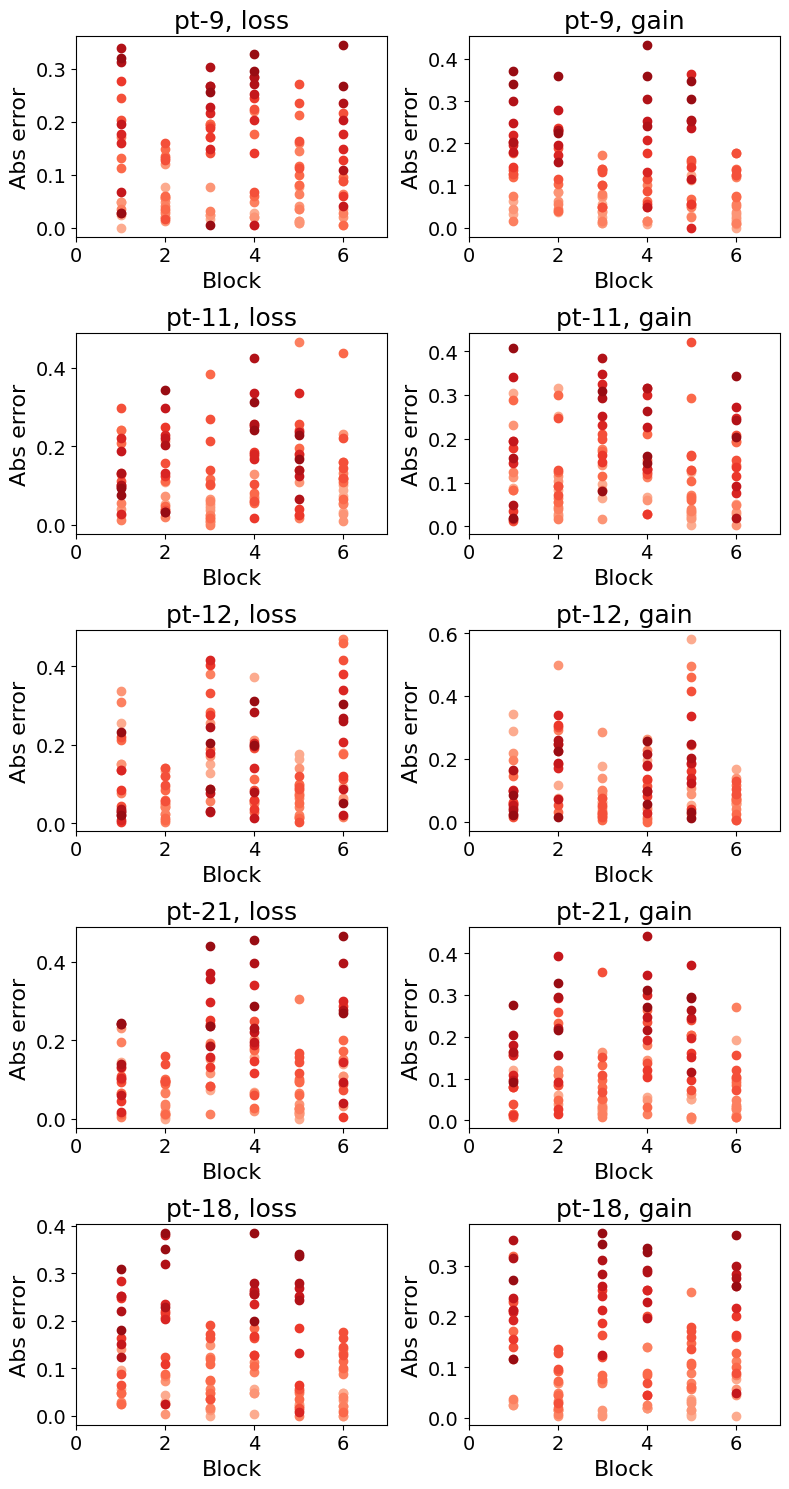

In [38]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
unique_cntxt_stims = sorted(df_analysis['stim_aligned_to_cntxt'].unique())
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(unique_cntxt_stims)))
color_map = dict(zip(unique_cntxt_stims, colors))
cntxt_rename = {'rew': 'gain', 'pen': 'loss'}

n_rows, n_cols = len(patients), 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axs, ax = axs.flatten(), 0
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    subj_df = df_analysis[df_analysis['subj'] == subj].copy()

    for cntxt in ['pen', 'rew']: # loss on left, gain on right
        cntxt_df = subj_df[subj_df['valence'] == cntxt].copy()
                    
        # scatter
        for cntxt_stim, cntxt_stim_df in cntxt_df.groupby('stim_aligned_to_cntxt'):

            for block, block_df in cntxt_stim_df.groupby('blockN'):
                print(block, block_df['stim_aligned_to_cntxt'].value_counts(), end='\n\n')

            axs[ax].scatter(cntxt_stim_df['blockN'], cntxt_stim_df['unsigned_err'], color=color_map[cntxt_stim])

            # # Calculate mean and SD of chosen position for each stimulus position
            # mean_chosen_per_stim = cntxt_stim_df.groupby('stim_aligned_to_cntxt')['unsigned_err'].agg(['mean', 'std']).reset_index()
            # mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
            
            # # mean
            # axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
            
            # # err bars
            # axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
            #                 yerr=mean_chosen_per_stim['std'], color=color_map[cntxt_stim])

        axs[ax].set(title=f'pt-{subj}, {cntxt_rename[cntxt]}',
                    xlabel='Block', ylabel='Abs error',
                    xlim=(0, 7))
        # axs[0].legend()
        ax += 1

# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3386647/2225784886.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cond_df['blockN'] = pd.Categorical(cond_df['blockN'], categories=block_order, ordered=True)


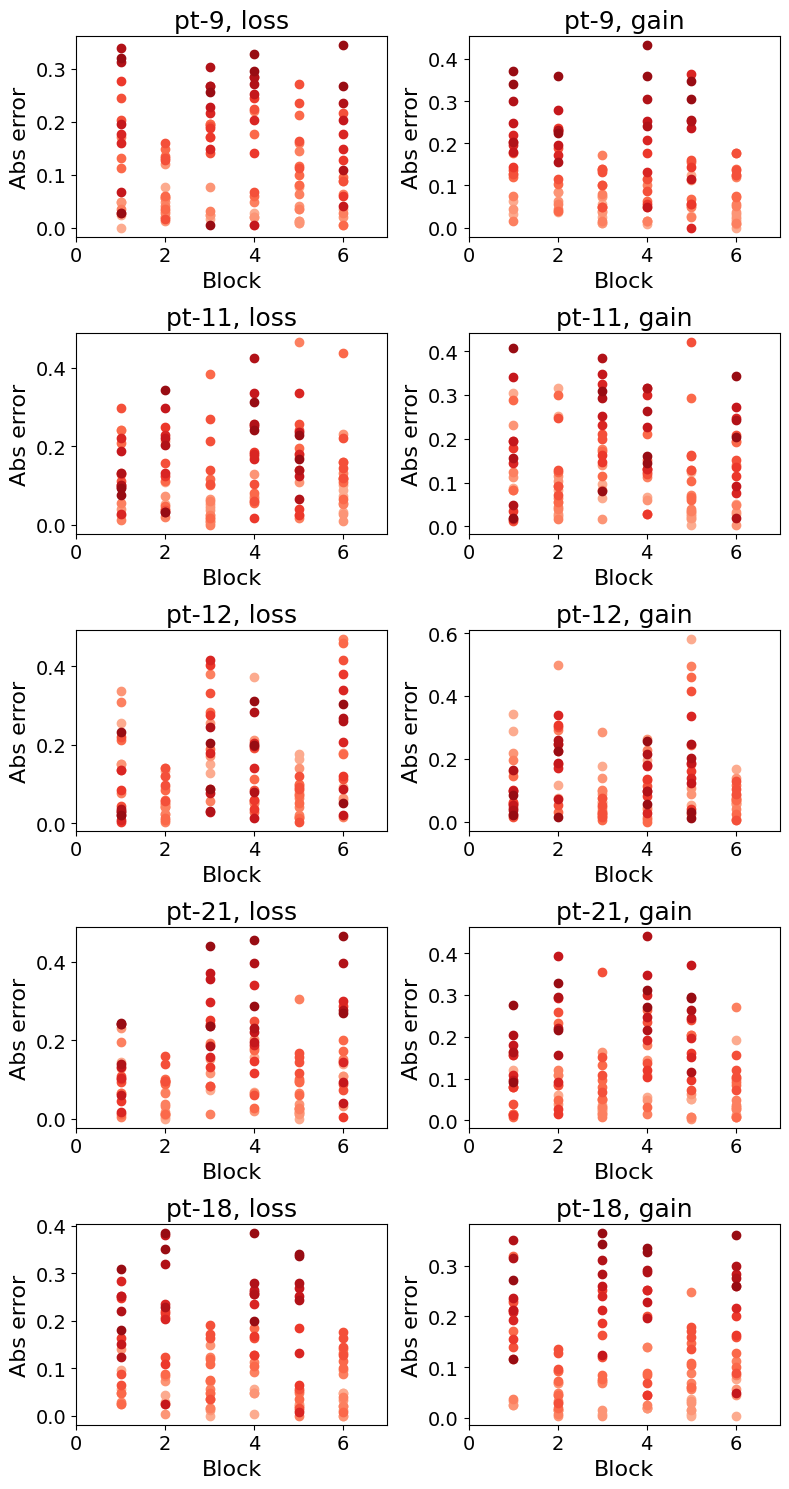

In [39]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
unique_cntxt_stims = sorted(df_analysis['stim_aligned_to_cntxt'].unique())
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(unique_cntxt_stims)))
color_map = dict(zip(unique_cntxt_stims, colors))
cntxt_rename = {'rew': 'gain', 'pen': 'loss'}
cond_rename = {'pen_comp': 'gain_exp', 'baseline': 'baseline', 'rew_comp': 'loss_exp'}
block_order = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

n_rows, n_cols = len(patients), 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axs, ax = axs.flatten(), 0
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    subj_df = df_analysis[df_analysis['subj'] == subj].copy()

    for cntxt in ['pen', 'rew']: # loss on left subplots, gain on right
        cntxt_df = subj_df[subj_df['valence'] == cntxt].copy()
        
        # scatter
        for cntxt_stim, cntxt_stim_df in cntxt_df.groupby('stim_aligned_to_cntxt'):
            
            for cond in conds:
                cond_df = cntxt_stim_df[cntxt_stim_df['condition'] == cond]

                cond_df['blockN'] = pd.Categorical(cond_df['blockN'], categories=block_order, ordered=True)
                axs[ax].scatter(cond_df['blockN'], cond_df['unsigned_err'], color=color_map[cntxt_stim])
                
            # for block, block_df in cntxt_stim_df.groupby('blockN'):
            #     print(block, block_df['stim_aligned_to_cntxt'].value_counts(), end='\n\n')

            # axs[ax].scatter(cntxt_stim_df['blockN'], cntxt_stim_df['unsigned_err'], color=color_map[cntxt_stim])

            # # Calculate mean and SD of chosen position for each stimulus position
            # mean_chosen_per_stim = cntxt_stim_df.groupby('stim_aligned_to_cntxt')['unsigned_err'].agg(['mean', 'std']).reset_index()
            # mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
            
            # # mean
            # axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
            
            # # err bars
            # axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
            #                 yerr=mean_chosen_per_stim['std'], color=color_map[cntxt_stim])

        axs[ax].set(title=f'pt-{subj}, {cntxt_rename[cntxt]}',
                    xlabel='Block', ylabel='Abs error',
                    xlim=(0, 7))
        # axs[0].legend()
        ax += 1

# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout()
plt.show()


1.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.02    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

5.0 stim_aligned_to_cntxt
0.02    4
Name: count, dtype: int64

6.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

1.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.06    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

5.0 stim_aligned_to_cntxt
0.06    4
Name: count, dtype: int64

6.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

1.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.1    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int

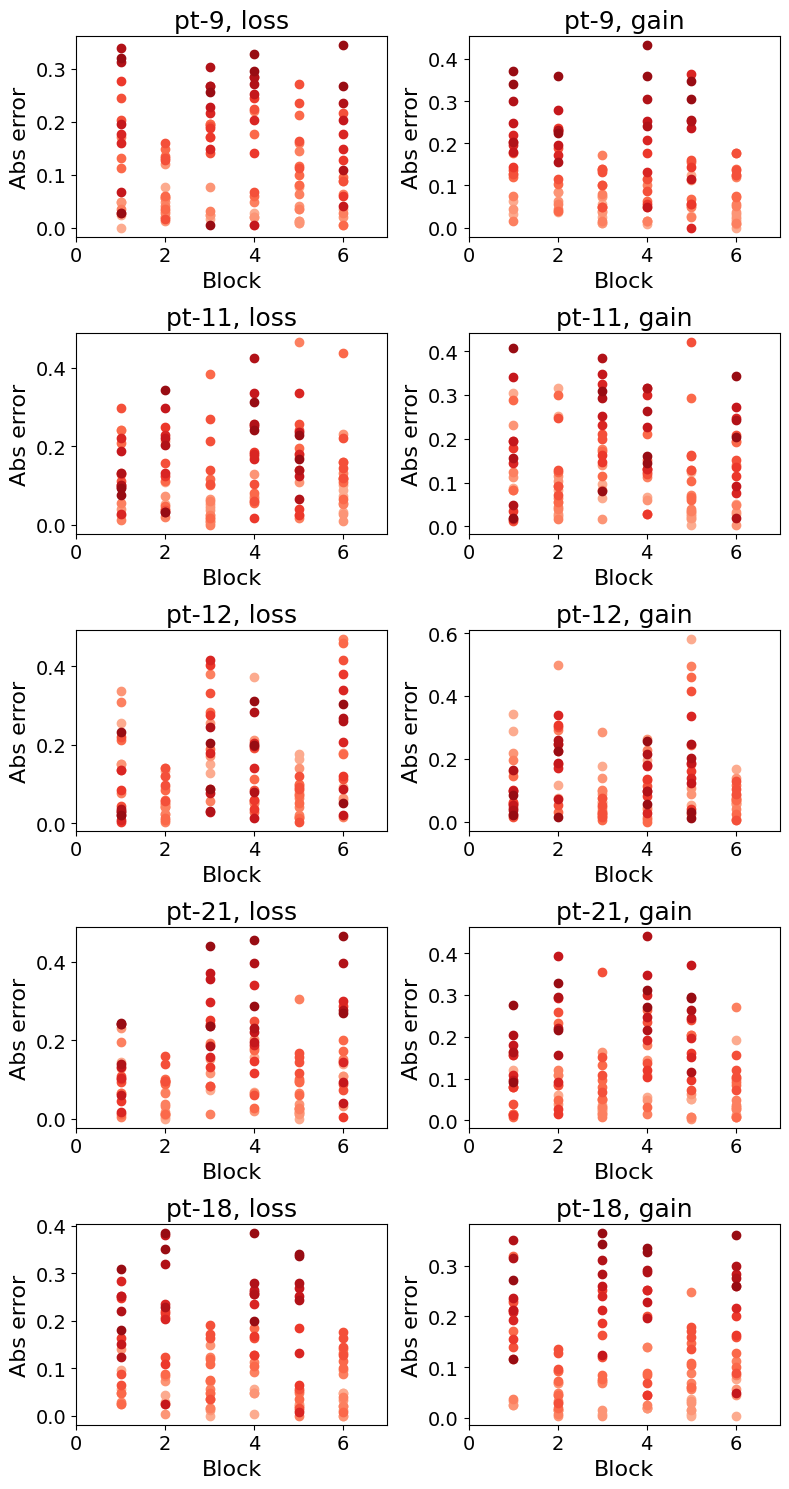

In [40]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
unique_cntxt_stims = sorted(df_analysis['stim_aligned_to_cntxt'].unique())
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(unique_cntxt_stims)))
color_map = dict(zip(unique_cntxt_stims, colors))
cntxt_rename = {'rew': 'gain', 'pen': 'loss'}

n_rows, n_cols = len(patients), 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axs, ax = axs.flatten(), 0
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    subj_df = df_analysis[df_analysis['subj'] == subj].copy()

    for cntxt in ['pen', 'rew']: # loss on left, gain on right
        cntxt_df = subj_df[subj_df['valence'] == cntxt].copy()
                    
        # plot
        for cntxt_stim, cntxt_stim_df in cntxt_df.groupby('stim_aligned_to_cntxt'):

            for block, block_df in cntxt_stim_df.groupby('blockN'):
                print(block, block_df['stim_aligned_to_cntxt'].value_counts(), end='\n\n')

            axs[ax].scatter(cntxt_stim_df['blockN'], cntxt_stim_df['unsigned_err'], color=color_map[cntxt_stim])

            # # Calculate mean and SD of chosen position for each stimulus position
            # mean_chosen_per_stim = cntxt_stim_df.groupby('stim_aligned_to_cntxt')['unsigned_err'].agg(['mean', 'std']).reset_index()
            # mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
            
            # # mean
            # axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
            
            # # err bars
            # axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
            #                 yerr=mean_chosen_per_stim['std'], color=color_map[cntxt_stim])

        axs[ax].set(title=f'pt-{subj}, {cntxt_rename[cntxt]}',
                    xlabel='Block', ylabel='Abs error',
                    xlim=(0, 7))
        # axs[0].legend()
        ax += 1

# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout()
plt.show()


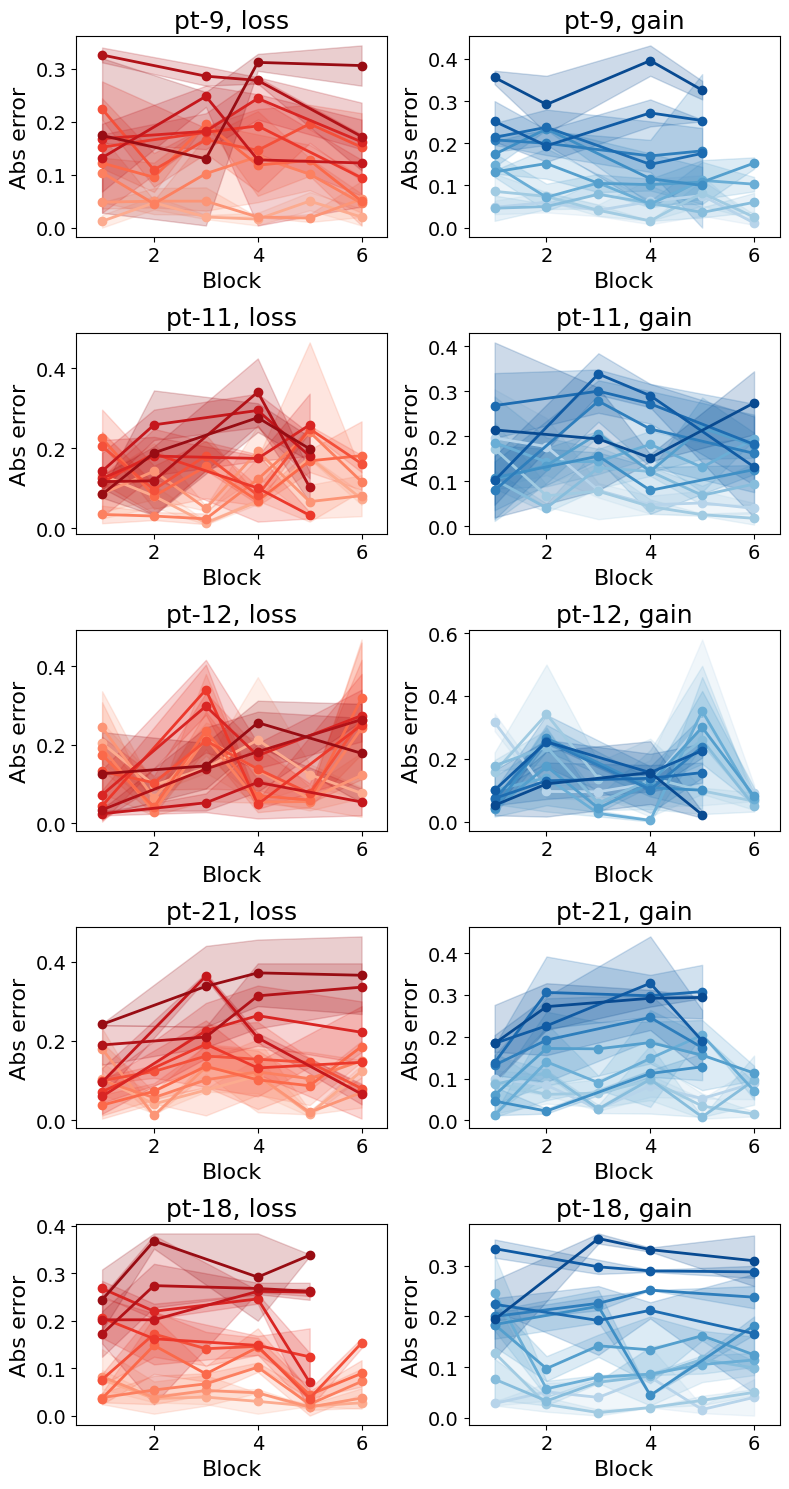

In [42]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
unique_cntxt_stims = sorted(df_analysis['stim_aligned_to_cntxt'].unique())
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(unique_cntxt_stims)))
color_map = dict(zip(unique_cntxt_stims, colors))
cntxt_rename = {'rew': 'gain', 'pen': 'loss'}
contexts     = ['pen', 'rew']  # loss = left, gain = right

# --- build separate colormaps per context (Reds for loss, Blues for gain) ---
color_maps = {}

for cntxt, cmap_name in zip(contexts, ['Reds', 'Blues']):
    sub = df_analysis[df_analysis['valence'] == cntxt]
    stims = np.sort(sub['stim_aligned_to_cntxt'].unique())
    colors = plt.get_cmap(cmap_name)(np.linspace(0.3, 0.9, len(stims)))
    color_maps[cntxt] = dict(zip(stims, colors))

# --- figure setup ---
n_rows, n_cols = len(patients), 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axs = axs.flatten()
ax_idx = 0

for subj in patients:

    subj_df = df_analysis[df_analysis['subj'] == subj]

    for cntxt in contexts:

        cntxt_df = subj_df[subj_df['valence'] == cntxt]

        # --- aggregate by (stim, blockN) ---
        grp = (cntxt_df
               .groupby(['stim_aligned_to_cntxt', 'blockN'])['unsigned_err']
               .agg(['mean', 'count', 'std'])
               .reset_index()
              )
        grp['sem'] = grp['std'] / np.sqrt(grp['count'])

        # --- line per stim ---
        for stim, stim_df in grp.groupby('stim_aligned_to_cntxt'):
            stim_df = stim_df.sort_values('blockN')

            axs[ax_idx].plot(
                stim_df['blockN'],
                stim_df['mean'],
                marker='o',
                color=color_maps[cntxt][stim],
                label=stim,
                linewidth=2,
            )

            # Optional: SEM shading
            axs[ax_idx].fill_between(
                stim_df['blockN'],
                stim_df['mean'] - stim_df['sem'],
                stim_df['mean'] + stim_df['sem'],
                color=color_maps[cntxt][stim],
                alpha=0.2,
            )

        axs[ax_idx].set(
            title=f'pt-{subj}, {cntxt_rename[cntxt]}',
            xlabel='Block',
            ylabel='Abs error',
            xlim=(0.5, 6.5),
        )

        ax_idx += 1

plt.tight_layout()
plt.show()


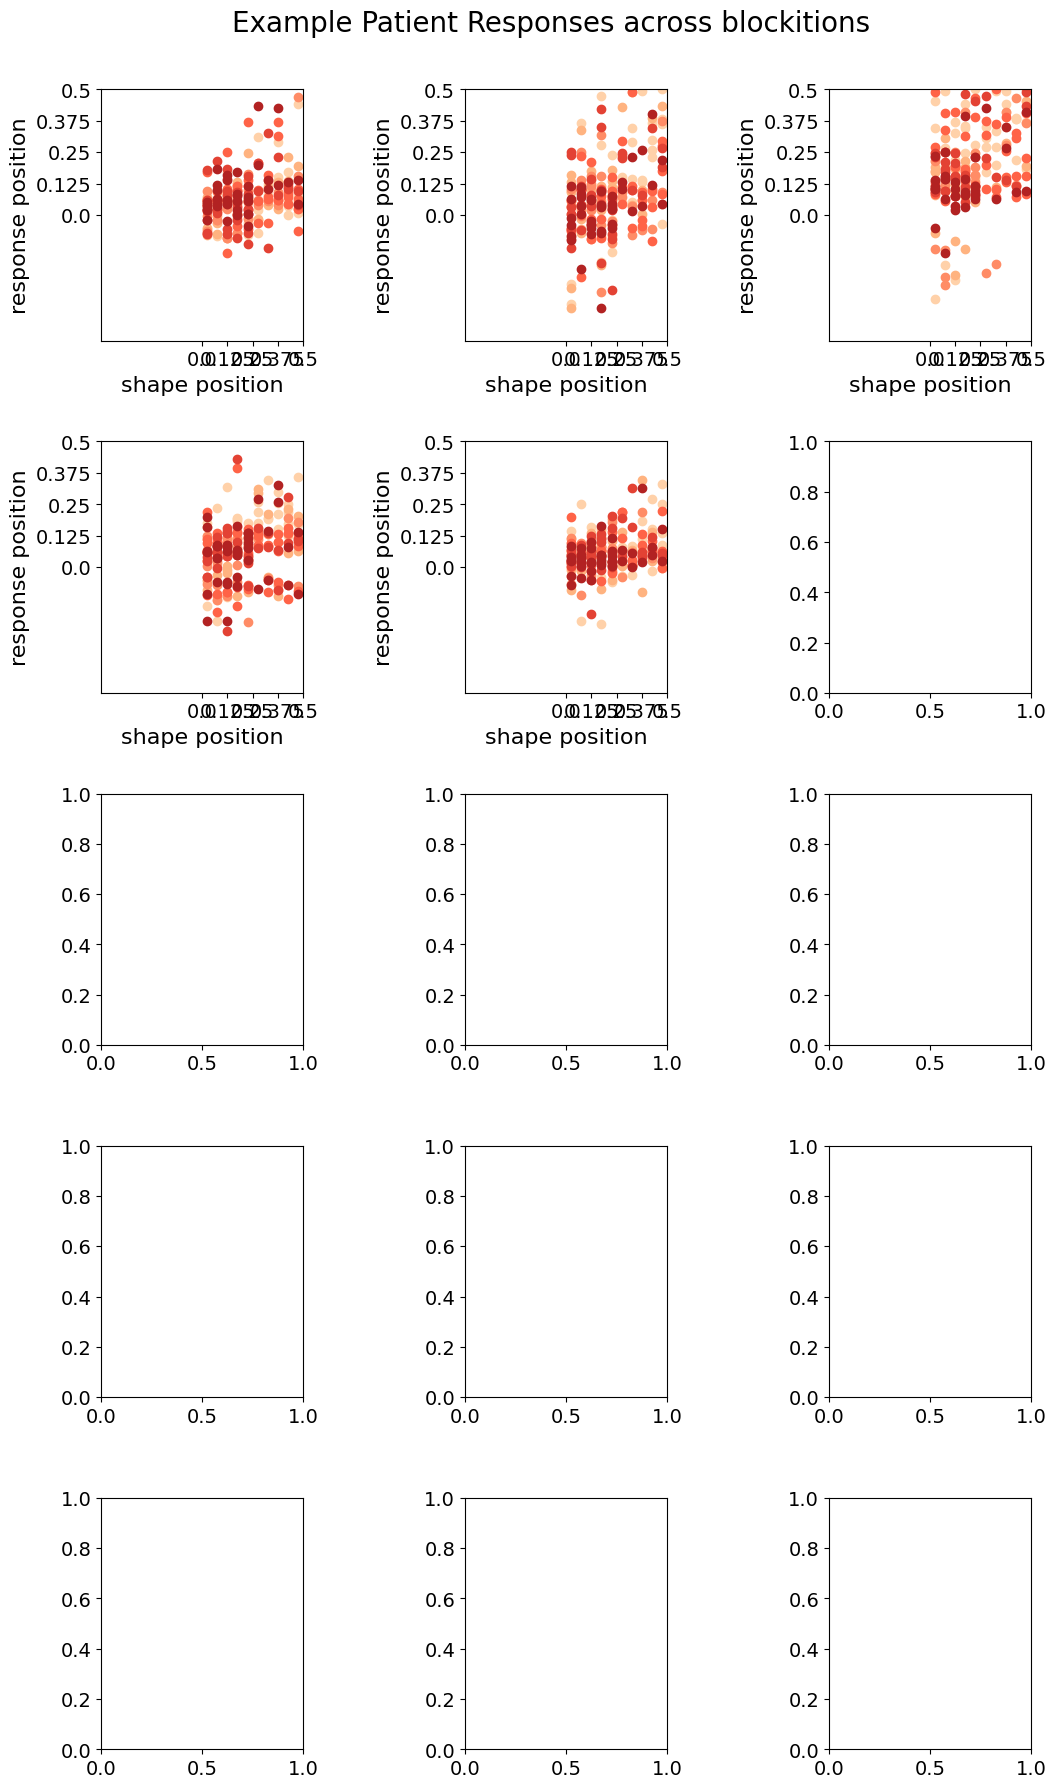

In [43]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
color_map = {1.0: '#FFD1A9', 2.0: '#FFB380', 3.0: '#FF8C66', 4.0: '#FF6347', 5.0: '#E34234', 6.0: '#B22222'}
label_map = {1.0: 'block 1', 2.0: 'block 2', 3.0: 'block 3', 4.0: 'block 4', 5.0: 'block 5', 6.0: 'block 6'}

n_rows, n_cols = len(patients), 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axs, ax = axs.flatten(), 0
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    axs[ax].set(xlabel='shape position', ylabel='response position',
                xlim=(-.4, .4), ylim=(-.4, .4),
                xticks=ticks, xticklabels=labels, yticks=ticks, yticklabels=labels)
        
    for block in np.arange(1.0, 6.1, 1.0):
        subj_block_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['blockN'] == block)].copy()

        # axs[ax].plot([0, .4], [0, .4], 'k--', alpha=0.5) # diagonal

        # # divider
        # div_pos = subj_block_df['div_pos_aligned'].iloc[0]
        # axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
        # axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)
                
        # scatter
        for block, block_df in subj_block_df.groupby('blockN'):        
            axs[ax].scatter(block_df['stim_aligned_to_cntxt'], block_df['resp_aligned_to_cntxt'],
                            color=color_map[block], label=label_map[block])
                
        # # Calculate mean and SD of chosen position for each stimulus position
        # mean_chosen_per_stim = subj_block_df.groupby('stim_aligned_to_cntxt')['resp_aligned_to_cntxt'].agg(['mean', 'std']).reset_index()
        # mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
        
        # # mean
        # axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
        
        # # err bars
        # axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
        #                 yerr=mean_chosen_per_stim['std'], color= 'red')

    ax += 1

# axs[1].legend()
plt.suptitle('Example Patient Responses across blockitions', fontsize=20)
fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
# plt.tight_layout()
plt.show()


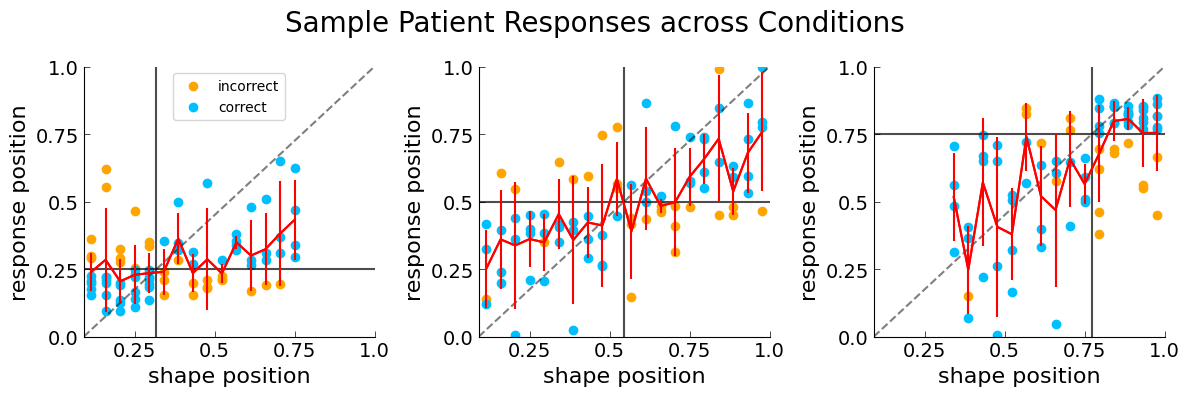

In [44]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, patients[1])

# plot info
color_map = {False: 'orange', True: 'deepskyblue'}
label_map = {False: 'incorrect', True: 'correct'}

n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axs, ax = axs.flatten(), 0
ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)

for cond in conds:
    subj_cond_df = df_analysis[df_analysis['condition'] == cond].copy()

    # diagonal for perfect accuracy
    axs[ax].plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)    
    # divider
    div_pos = subj_cond_df['div_pos_aligned'].iloc[0]
    axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
    axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)

    # set
    axs[ax].set(xlabel='shape position', ylabel='response position',
                xlim=(-.4, .4), ylim=(-.4, .4),
                xticks=np.linspace(-.26, .4, 4), xticklabels=np.linspace(.25, 1, 4), yticks=ticks, yticklabels=labels)
                
    # scatter
    for acc, acc_df in subj_cond_df.groupby('correct'):        
        axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'],
                        color=color_map[acc], label=label_map[acc])
            
    # Calculate mean and SD of chosen position for each stimulus position
    mean_chosen_per_stim = subj_cond_df.groupby('stim_pos_aligned')['chosen_pos_aligned'].agg(['mean', 'std']).reset_index()
    mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_pos_aligned')
    
    # mean
    axs[ax].plot(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], color='red')
    
    # err bars
    axs[ax].errorbar(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], 
                    yerr=mean_chosen_per_stim['std'], color= 'red')

    ax += 1

axs[0].legend()
for ax in axs:
    ax.tick_params(direction='in', length=4, width=.5)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.suptitle('Sample Patient Responses across Conditions', fontsize=20)
# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout(h_pad=2)
plt.show()

# fig.savefig('../../results/figs/sfn/fig3b_scatter.eps', format='eps', dpi=300)
plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
fig.savefig('../../results/figs/sfn/fig3b_scatter.svg', format='svg', dpi=300)


## psychometric curves

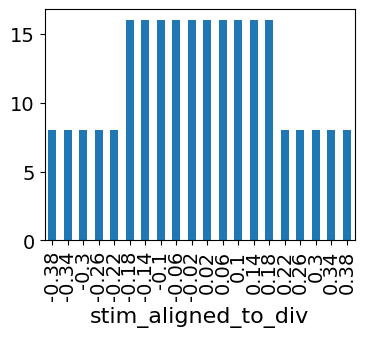

In [45]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, patients[2])
plt.figure(figsize=(4,3))
df_analysis['stim_aligned_to_div'].value_counts().sort_index().plot(kind='bar')
plt.show()

functions

In [47]:
from scipy.optimize import curve_fit
from scipy.stats import norm
unique_aligned_pos = np.unique(df_analysis['stim_aligned_to_div'])

def logistic(x, threshold, slope):
    return 1 / (1 + np.exp(-(x - threshold) / slope))

def get_subj_psychometric(subj):
    
    subj_df = df_analysis[df_analysis['subj'] == subj]

    subjs_props, subjs_sderrs = [], []

    # calculate proportion right and sd errs per position
    for aligned_pos in unique_aligned_pos:
        
        # all trials with this aligned_pos
        stim_pos_trials = subj_df[subj_df['stim_aligned_to_div'] == aligned_pos]

        # proportion and sderr of pred_class == 1
        prop = stim_pos_trials['pred_class'].mean()
        stderr = np.sqrt(prop * (1 - prop) / len(stim_pos_trials))

        subjs_props.append(prop)
        subjs_sderrs.append(stderr)

    return np.array(subjs_props), np.array(subjs_sderrs)


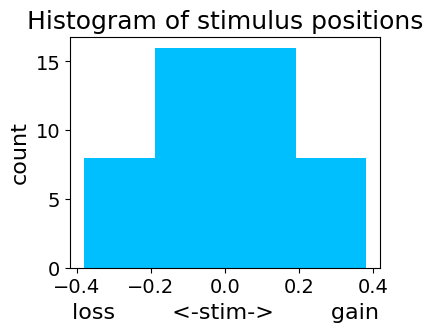

In [48]:
# hist of positions to div
plt.figure(figsize=(4,3))
plt.hist(df_analysis['stim_aligned_to_div'], bins=20, color='deepskyblue')
plt.xlabel('loss        <-stim->        gain')
plt.ylabel('count')
plt.title('Histogram of stimulus positions')
plt.show()

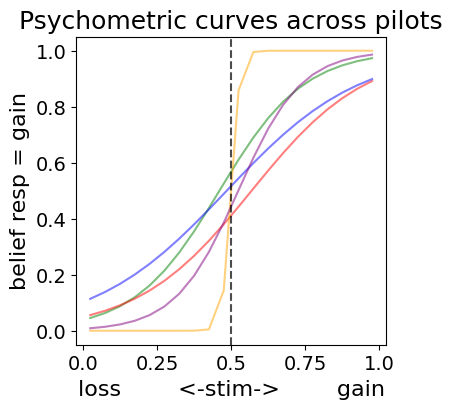

In [50]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

plt.figure(figsize=(4, 4))
ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)

for pt_idx in range(len(patients)):
    props, sderrs = get_subj_psychometric(patients[pt_idx])

    # fit logistic curve
    param_init = [0, 1]
    [bias, slope], _ = curve_fit(logistic, unique_aligned_pos, props, p0=param_init)
    fitted_curve = logistic(unique_aligned_pos, *[bias, slope])
    
    # plt.errorbar(unique_aligned_pos, props, yerr=1.96*sderrs, fmt='o', ms=3, alpha=0.7)
    plt.plot(unique_aligned_pos, fitted_curve, alpha=0.5, color=pt_colors[pt_idx])
    
    plt.xticks(ticks, labels) # reformat

plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f'Psychometric curves across pilots')
plt.xlabel('loss        <-stim->        gain')
plt.ylabel('belief resp = gain')
plt.show()

## accuracy & RT by position

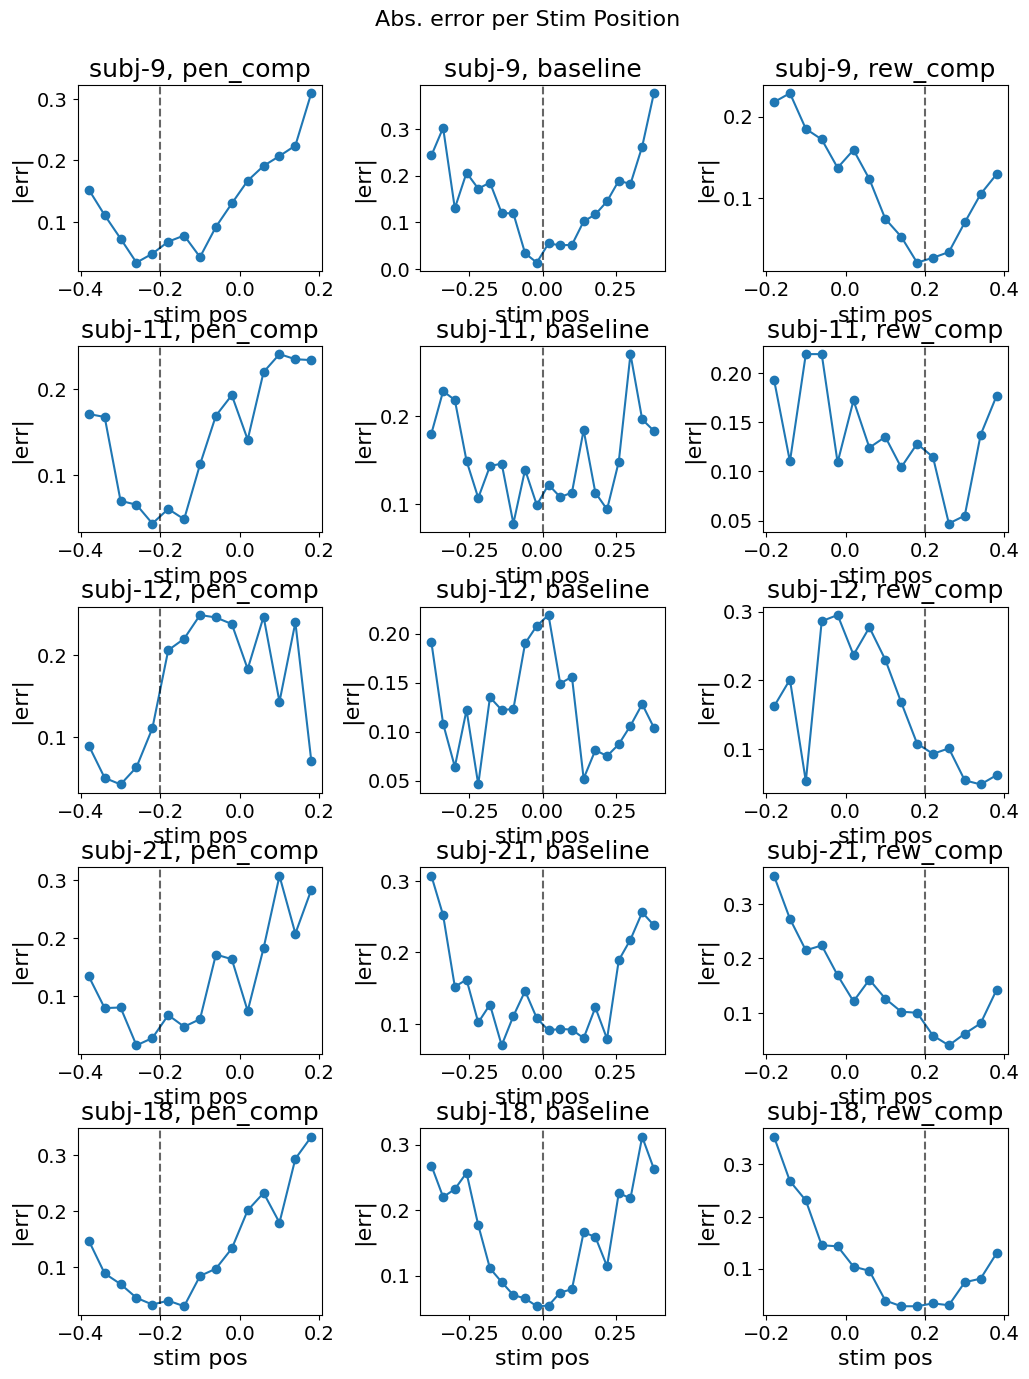

In [51]:
fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        subj_cond_df['|err|'] = np.abs(subj_cond_df['stim_pos_aligned'] - subj_cond_df['chosen_pos_aligned'])
        err_by_stim = subj_cond_df.groupby('stim_pos_aligned')['|err|'].mean()

        axs[ax].plot(err_by_stim.index, err_by_stim.values, marker='o')
        axs[ax].axvline(subj_cond_df['div_pos_aligned'].iloc[0], color='k', linestyle='--', alpha=0.6)
        axs[ax].set(title=f'subj-{subj}, {cond}', xlabel='stim pos', ylabel='|err|')

        ax += 1

plt.suptitle(f'Abs. error per Stim Position', fontsize=16)
fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
plt.show()


In [ ]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i, (cond, cond_df) in enumerate(df_analysis.groupby('condition')):
    mean_metrics = cond_df.groupby('stim_pos_aligned')[['correct', 'normed_RT']].mean().reset_index()
    sem_metrics  = cond_df.groupby('stim_pos_aligned')[['correct', 'normed_RT']].sem().reset_index()
    
    # Accuracy plot (col 1)
    axs[i, 0].set(xlabel='penalizing        <--    shape position   -->        rewarding', 
                  ylabel='accuracy', xlim=(-.4, .4), title=f'{cond} - Accuracy')
    axs[i, 0].plot(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], marker='o')
    axs[i, 0].errorbar(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], 
                       yerr=sem_metrics['correct'].values, capsize=5)
    axs[i, 0].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
    
    # RT plot (col 2)
    axs[i, 1].set(xlabel='penalizing        <--    shape position   -->        rewarding', 
                  ylabel='normed RT', xlim=(-.4, .4), title=f'{cond} - normed RT')
    axs[i, 1].plot(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], marker='o', color='orange')
    axs[i, 1].errorbar(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], 
                       yerr=sem_metrics['normed_RT'].values, capsize=5)
    axs[i, 1].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')

plt.suptitle(f'Accuracy & RT by Position for subj-{subj_or_pop}', fontsize=16)
plt.tight_layout()
plt.show()


# 6. analyses by valence & compression

In [ ]:
# df_plot = df_hard.copy()
df_plot = df_analysis.copy()

df_plot['correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['condition'].value_counts())
print(df_plot['correct'].value_counts())
print(df_plot['outcome'].value_counts())

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence & compression on subj')
palette, hue_order = {'rew': 'blue', 'pen': 'red'}, ['pen', 'rew']

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='condition', y='correct', hue='valence', hue_order=hue_order, palette = palette, ax=ax, errorbar=None)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()

# 2.
# ax = axes[1]
# sns.boxplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order,
#             palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
# sns.stripplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order, 
#               dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('Mean Absolute Error')
# ax.legend()

# 3.
ax = axes[2]
sns.boxplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()

## analyses by valence space

In [ ]:
df_plot = df_analysis.copy()

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df_plot['percept_space'] = np.select(conditions, percept_labels, default= 'undefined')

# arnav's percept space will be flipped
print(df_plot['percept_space'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effect of perceptual space on subj')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', width=0.6, ax=ax, errorbar=None, order=percept_labels)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')

# 2. MAE
# ax = axes[1]
# sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
# sns.stripplot(data=df_plot, x='percept_space', y='MAE_normed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, order=percept_labels, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_ylim(0, .6)
# ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
# ax.set_title('Mean Absolute Error (questionable norming)')

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, order=percept_labels, ax=ax)
sns.stripplot(data=df_plot, x='percept_space', y='outcome', dodge=True, alpha=0.8, jitter=True, order=percept_labels, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, order=percept_labels, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')

plt.tight_layout()
plt.show()



## plot class - class_hat

In [ ]:
# Step 1: Get mean accuracy per subject (across all conditions and valences)
subj_acc = df_subjs.groupby('subj')['correct'].mean().reset_index()

# Step 2: Compute SD across those subject-level accuracies
overall_sd = subj_acc['correct'].std()

print(f"SD across subjects: {overall_sd}")


In [ ]:
# compute subject-level accuracy by valence & condition
subj_acc_df = df_subjs.groupby(['subj','condition','valence'])['correct'].mean().reset_index()

subj_acc_df['x_label'] = subj_acc_df['valence'].astype(str) + '\n' + subj_acc_df['condition'].astype(str)

# assign colors to subjects
subj_palette = dict(zip(subj_acc_df['subj'].unique(),
                        sns.color_palette('husl', n_colors=subj_acc_df['subj'].nunique())))

# compute population mean by condition & valence
pop_acc_df = subj_acc_df.groupby(['condition','valence'])['correct'].mean().reset_index()
pop_acc_df['x_label'] = pop_acc_df['valence'].astype(str) + '\n' + pop_acc_df['condition'].astype(str)

fig, axs = plt.subplots(2, 2, figsize=(12, 5))
axs, ax = axs.flatten(), 0

axs[ax].set_title('Accuracy')
# plot subjs
for subj, sub_df in subj_acc_df.groupby('subj'):
    for cond, cond_df in sub_df.groupby('condition'):
        axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                     color=subj_palette[subj], alpha=0.6)

# plot population
for cond, cond_df in pop_acc_df.groupby('condition'):
    axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                 color='black', marker='o', linewidth=2)

axs[ax].set(ylabel='proportion', ylim=(.5, 1))
ax += 1

# post error behavior
axs[ax].set_title('Post-error behavior')
df_post_err = df_subjs[df_subjs['correct'].shift(-1) == False]

plt.tight_layout()
plt.show()


## rewards

In [ ]:
# filter + safe copy
df_attempted = df_analysis.loc[df_analysis['outcome'].isin([1, -1, 3, -3])].copy()

val_order = [3, 1, -3, -1]                  # desired order
label   = [str(v) for v in val_order]         # or ["+3","+1","−3","−1"]

fig, axs = plt.subplots(len(subjs), 3, figsize=(20, 3*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in df_attempted['condition'].unique():
        
        subj_cond_df = df_attempted[(df_attempted['subj'] == subj) &
                          (df_attempted['condition'] == cond)]

        # counts in desired order (fill zeros)
        counts = subj_cond_df['outcome'].value_counts().reindex(val_order, fill_value=0)

        # plot using fixed positions
        axs[ax].bar(range(4), counts.values, color='#64B5F6')

        axs[ax].set_ylim(0, 40)
        axs[ax].set_xticks(range(4))
        axs[ax].set_xticklabels(label, fontsize=18)
        axs[ax].tick_params(axis='y', labelsize=18)
        axs[ax].set_title(f'subj-{subj}, {cond}', fontsize=18)
        ax += 1

plt.suptitle('Histogram of Outcome Values', fontsize=20, y=.99)
plt.tight_layout()
plt.show()
